## Modeling

we start by using a lazy regressor to have from the lazy predict library to have an idea of which model could be a good fit  

In [1]:
# Import necessary libraries
import pandas as pd
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from Scripts import preprocessing

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_validate
import optuna
import numpy as np

# Load data
df = pd.read_csv("../data/train_set.csv")

# Split data into training and validation sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, valid_index in split.split(df, df["Cylinders"]):
    train_set = df.loc[train_index]
    valid_set = df.loc[valid_index]

# Separate features and target
X_train = train_set.drop("MPG", axis=1)
y_train = train_set["MPG"].copy()
X_valid = valid_set.drop("MPG", axis=1)
y_valid = valid_set["MPG"].copy()

# Initialize LazyRegressor and fit the model
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_valid, y_train, y_valid)
model_dictionary = reg.provide_models(X_train, X_valid, y_train, y_valid)

100%|██████████| 42/42 [00:06<00:00,  6.62it/s]


In [2]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.89,0.90,2.13,0.25
GradientBoostingRegressor,0.87,0.88,2.35,0.13
HistGradientBoostingRegressor,0.86,0.87,2.47,0.32
LGBMRegressor,0.85,0.86,2.51,0.35
RandomForestRegressor,0.85,0.86,2.54,0.35
KNeighborsRegressor,0.84,0.85,2.61,0.05
BaggingRegressor,0.83,0.85,2.66,0.05
SVR,0.83,0.84,2.71,0.02
XGBRegressor,0.83,0.84,2.71,0.23


based on these results we decided to go with  GradientBoostingRegressor ( good rmse and low execution time)
then we can look at the pipeline to have an idea of the preprocing steps used. if we are happy with that we can use the same preprocessing steps otherwise we can adjust

In [40]:
model_dictionary['GradientBoostingRegressor']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Origin'],
      dtype='object')),
                                                 ('categorical_low',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index([], dtype='object')),
                                                 ('categorical_high',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  Index([], dtype='object'))])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

using own one preprocessing script, let's build the based line model and compute it RMSE

In [3]:
X_train, y_train, scaler = preprocessing.preprocess(train_set,train=True)
X_valid, y_valid, scaler = preprocessing.preprocess(valid_set,scaler=scaler)

model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)
val_predictions = model.predict(X_valid)
baseline_rmse = np.sqrt(mean_squared_error(y_valid, val_predictions))
print(f'the baseline rmse is : {baseline_rmse}')

the baseline rmse is : 2.2991369212470567


let's now see if the rmse can be improved with hyperparameter tuning

#### Hyperparameter Tuning using Optuna
Optuna is a software framework for automating the optimization process of these hyperparameters. It automatically finds optimal hyperparameter values by making use of different samplers such as grid search, random, bayesian, and evolutionary algorithms.

Let's create the objective function and define the search space:
We built a grid of 7 hyperparameters with different ranges and some static ones for random seed and early stopping.

In [4]:
def objective(trial, X, y, cv, scoring):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 5000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2,9),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1,9),
        "subsample": trial.suggest_float("subsample", 0.1, 0.9, step=0.05),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "random_state": 42,
        "n_iter_no_change": 50,  # early stopping
        "validation_fraction": 0.05,
    }
    # Perform CV
    gr_reg = GradientBoostingRegressor(**params)
    scores = cross_validate(gr_reg, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    # Compute RMSLE
    rmse = np.sqrt(-scores["test_score"].mean())

    return rmse

The above objective function accepts additional arguments for the data sets, scoring and cv. That's why we have to wrap it inside another function

In [5]:
%%time

# Separate features and target
X, y, scaler = preprocessing.preprocess(df,train=True)

# Create study that minimizes
study = optuna.create_study(direction="minimize")

# Wrap the objective inside a lambda with the relevant arguments
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Pass additional arguments inside another function
func = lambda trial: objective(trial, X, y, cv=kf, scoring="neg_mean_squared_error")

# Start optimizing with 100 trials
study.optimize(func, n_trials=100)

[I 2023-04-12 15:26:39,331] A new study created in memory with name: no-name-369397d6-1ee7-4af6-b4af-0da8fc8067ac
[I 2023-04-12 15:26:54,910] Trial 0 finished with value: 2.8432730842842706 and parameters: {'n_estimators': 1300, 'learning_rate': 0.0073006157463816265, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 9, 'subsample': 0.4, 'max_features': 'log2'}. Best is trial 0 with value: 2.8432730842842706.
[I 2023-04-12 15:27:11,002] Trial 1 finished with value: 5.667383627327067 and parameters: {'n_estimators': 3550, 'learning_rate': 0.00011152891357936586, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 4, 'subsample': 0.9, 'max_features': 'sqrt'}. Best is trial 0 with value: 2.8432730842842706.
[I 2023-04-12 15:27:12,030] Trial 2 finished with value: 2.7152691005715854 and parameters: {'n_estimators': 1700, 'learning_rate': 0.052149464799994265, 'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 2, 'subsample': 0.7000000000000001, 'max_features': 

CPU times: total: 8.77 s
Wall time: 2min 23s


In [6]:
print(f"Optimized RMSE: {study.best_value:.5f}")

Optimized RMSE: 2.64503


In [7]:
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Best params:
	n_estimators: 1200
	learning_rate: 0.06553336968800896
	max_depth: 19
	min_samples_split: 2
	min_samples_leaf: 1
	subsample: 0.65
	max_features: log2


Optuna offers a wide range of plots under its visualization subpackage. Here, we will discuss only 2, which I think are the most useful.

First, let's plot the optimization history of the last study:

In [8]:
from optuna.visualization import plot_optimization_history

plotly_config = {"staticPlot": True}

fig = plot_optimization_history(study)
fig.show(config=plotly_config)

This plot tells us that Optuna made the score converge to the minimum after only a few trials.

Next, let's plot hyperparameter importances:

In [9]:
from optuna.visualization import plot_param_importances

fig = plot_param_importances(study)
fig.show(config=plotly_config)

This plot is massively useful! It tells us several things, including:

- learning_rate , subsample and n_estimator are the most important
- max_features, min_samples_leaf and min_samples_split are useless for minimizing the loss

A plot like this comes in handy when tuning models with many hyperparameters. For example, you could take a test run of 40–50 trials and plot the parameter importances.

Depending on the plot, you might decide to discard some less important parameters and give a larger search space for other ones, possibly reducing the search time and space.

the tuning did not improve the rmse But you can play around with optuna and add other hyperparameter to see if you can improve the rmse 

In [18]:
best_params=study.best_params
model= GradientBoostingRegressor(**best_params)
model.fit(X, y)

GradientBoostingRegressor(learning_rate=0.06553336968800896, max_depth=19,
                          max_features='log2', n_estimators=1200,
                          subsample=0.65)

now we can test the model with unseen data

In [20]:

df = pd.read_csv("../data/test_set.csv")

# Separate features and target

X_test, y_test, scaler = preprocessing.preprocess(df,scaler=scaler)

final_predictions = model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_rmse

2.7287984923534383

we can even plot the actual vs predicted 

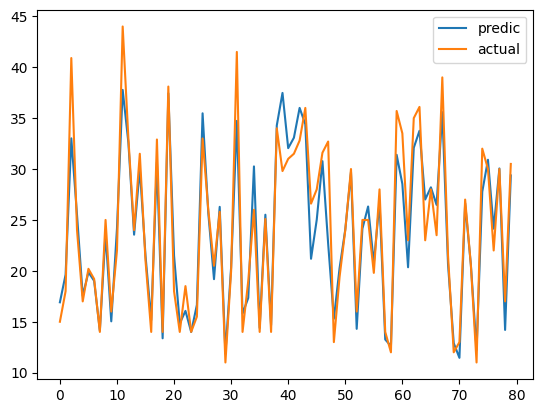

In [21]:
import matplotlib.pyplot as plt
plt.plot(final_predictions,label='predic')
plt.plot(y_test,label='actual')
plt.legend()

let's now visualize the features importance

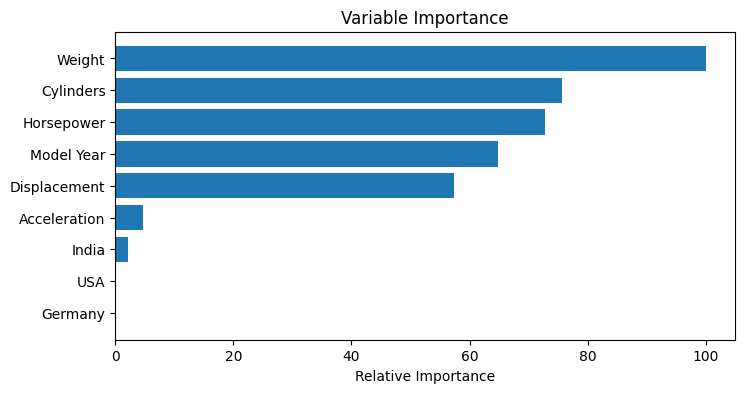

In [77]:
feature_importance = model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 4))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

from this plot we can see the most important feature. those that have very low contribution could be removed. for the moment we will proceed with the model like that but fell free to keep improving the model until you are happy with it.

### Saving the Trained Model for deployment

In [23]:
import pickle

##dump the model into a file
with open("../model/model.bin", 'wb') as f_out:
    pickle.dump(model, f_out) # write final_model in .bin file
    f_out.close()  # close the file 

let's also saved the fitted scaler used during the training

In [26]:
import joblib
joblib.dump(scaler, '../model/scaler.save') 

['../model/scaler.save']

let's test if we are able to use the saved model to make predictions.

In [30]:
# we defined this function to cover the entire flow
def predict_mpg(config, model):
    
    if type(config) == dict:
        df = pd.DataFrame(config)
    else:
        df = config
    
    scaler = joblib.load('../model/scaler.save')

    X_test, _, _ = preprocessing.preprocess(df,scaler=scaler)

    y_pred = model.predict(X_test)
    
    return y_pred

In [28]:
##loading the model from the saved file
with open('../model/model.bin', 'rb') as f_in:
    model = pickle.load(f_in)

In [29]:
##vehicle config
vehicle_config = {
    'Cylinders': [4, 6, 8],
    'Displacement': [155.0, 160.0, 165.5],
    'Horsepower': [93.0, 130.0, 98.0],
    'Weight': [2500.0, 3150.0, 2600.0],
    'Acceleration': [15.0, 14.0, 16.0],
    'Model Year': [81, 80, 78],
    'Origin': [3, 2, 1]
}

In [35]:
# import importlib
# importlib.reload(preprocessing)

predict_mpg(vehicle_config, model)

array([24.35272207, 16.64935604, 22.27148741])